In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import os
import scipy.stats as scs
import os.path
from os import path

In [4]:
def kde(a, w):
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

### Building dataset

In [21]:
dataset = {
    'name': ('Hst5','Sic1','aSyn','Tau','ProTa','GHR-ICD','NHE6cmdd','ANAC046'),
    'length': (24, 90, 140, 441, 110, 351, 116, 167),
    'ensemble_size': (10000, 15000, 20000, 30000, 15000, 25000, 15000, 20000),
    'Rh': (1.275, 2.15, 2.86, 5.20, 4.10, 5.18, 2.66, 3.04),
    'Rh_err': (0.024, 0.11, 0.07, 0.2, 0, 0, 0, 0.01)
}
dataset = pd.DataFrame(dataset).sort_values('length').set_index('name')
dataset.to_csv('/storage1/francesco/PROJECTS/EXP_DATA/Rh.csv')

In [18]:
dataset

,length,ensemble_size,Rh,Rh_err
name,,,,
Hst5,24,10000,1.275,0.024
Sic1,90,15000,2.150,0.110
ProTa,110,15000,4.100,0.000
NHE6cmdd,116,15000,2.660,0.000
aSyn,140,20000,2.860,0.070
ANAC046,167,20000,3.040,0.010
GHR-ICD,351,25000,5.180,0.000
Tau,441,30000,5.200,0.200


In [115]:
exp_saxs = [
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Hst5/saxs293k_bme.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Sic1/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/ProTa/prota_saxs_C.dat'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/NHE6cmdd/saxs_NHE6cmdd_C.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/aSyn/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/ANAC046/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/GHR-ICD/exp_saxs_150mM_1p7mg.dat'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Tau/exp_saxs.txt')
]
dataset['exp_saxs'] = exp_saxs

### Analyse iBME(SAXS) results

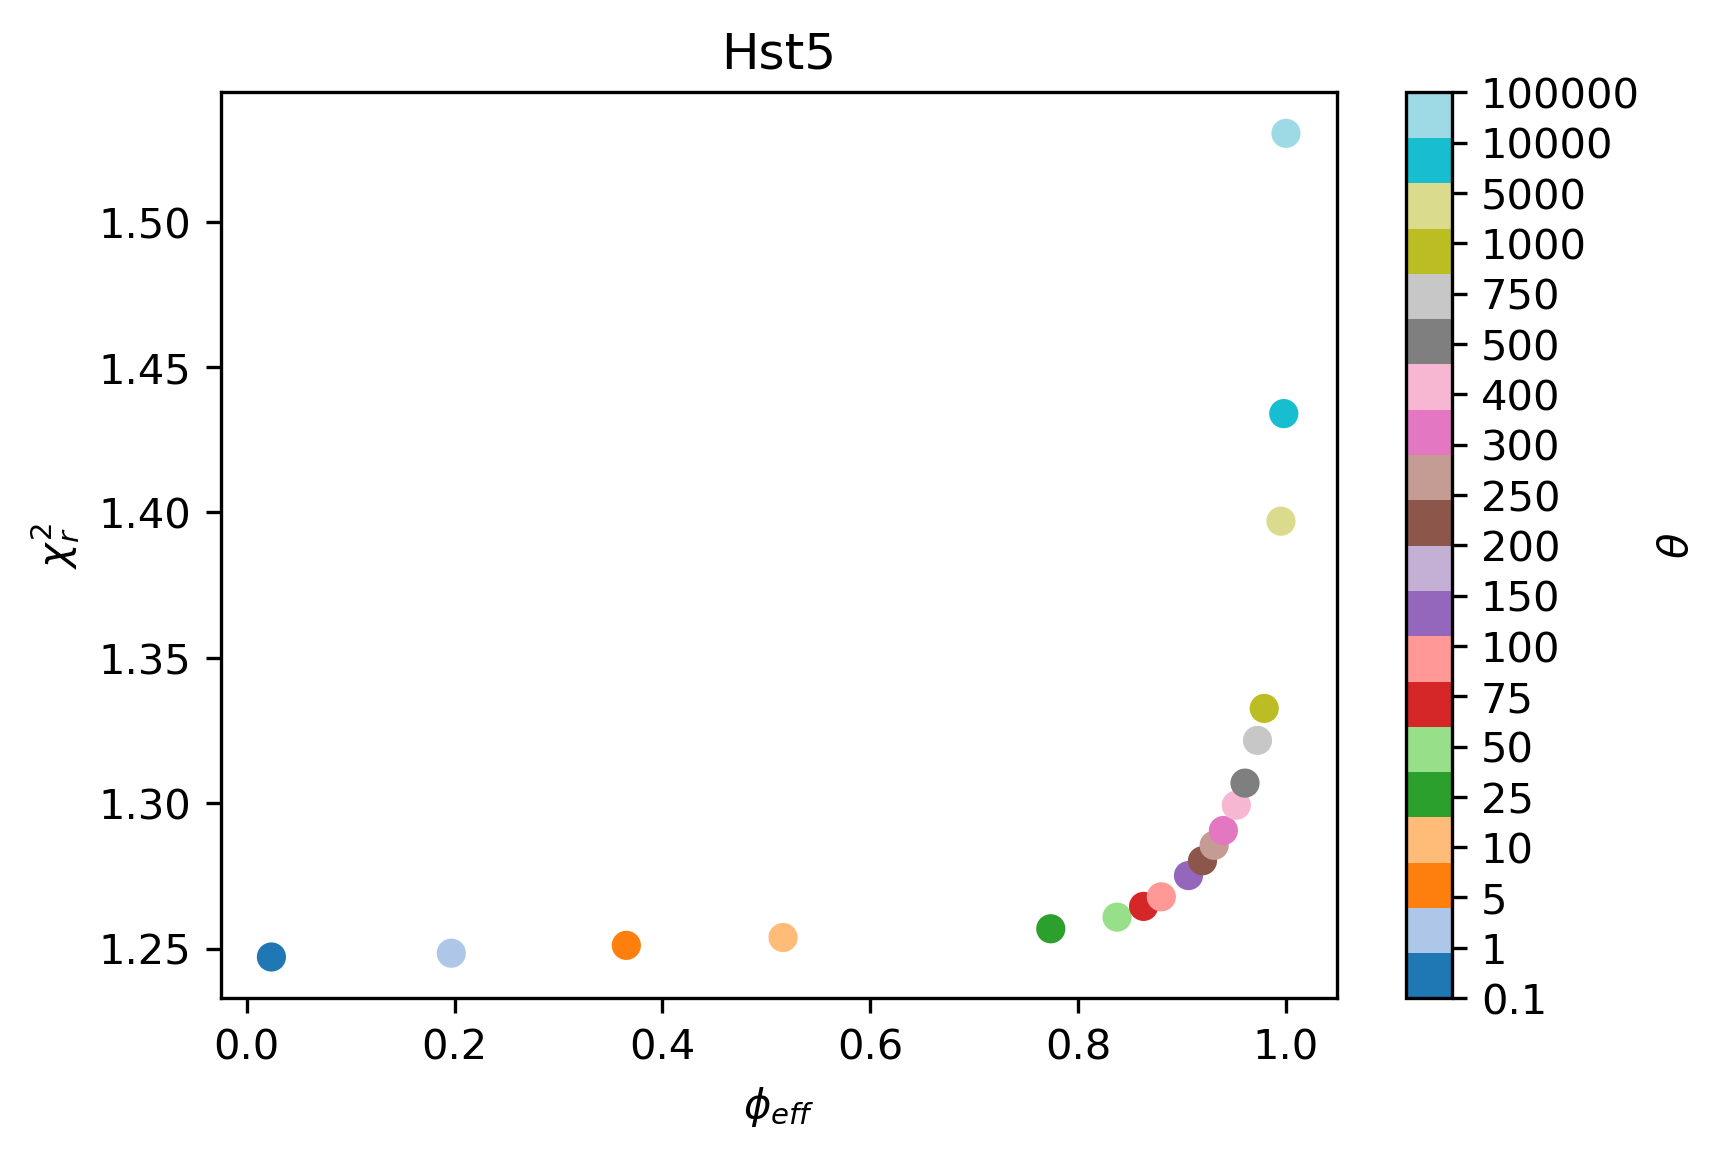

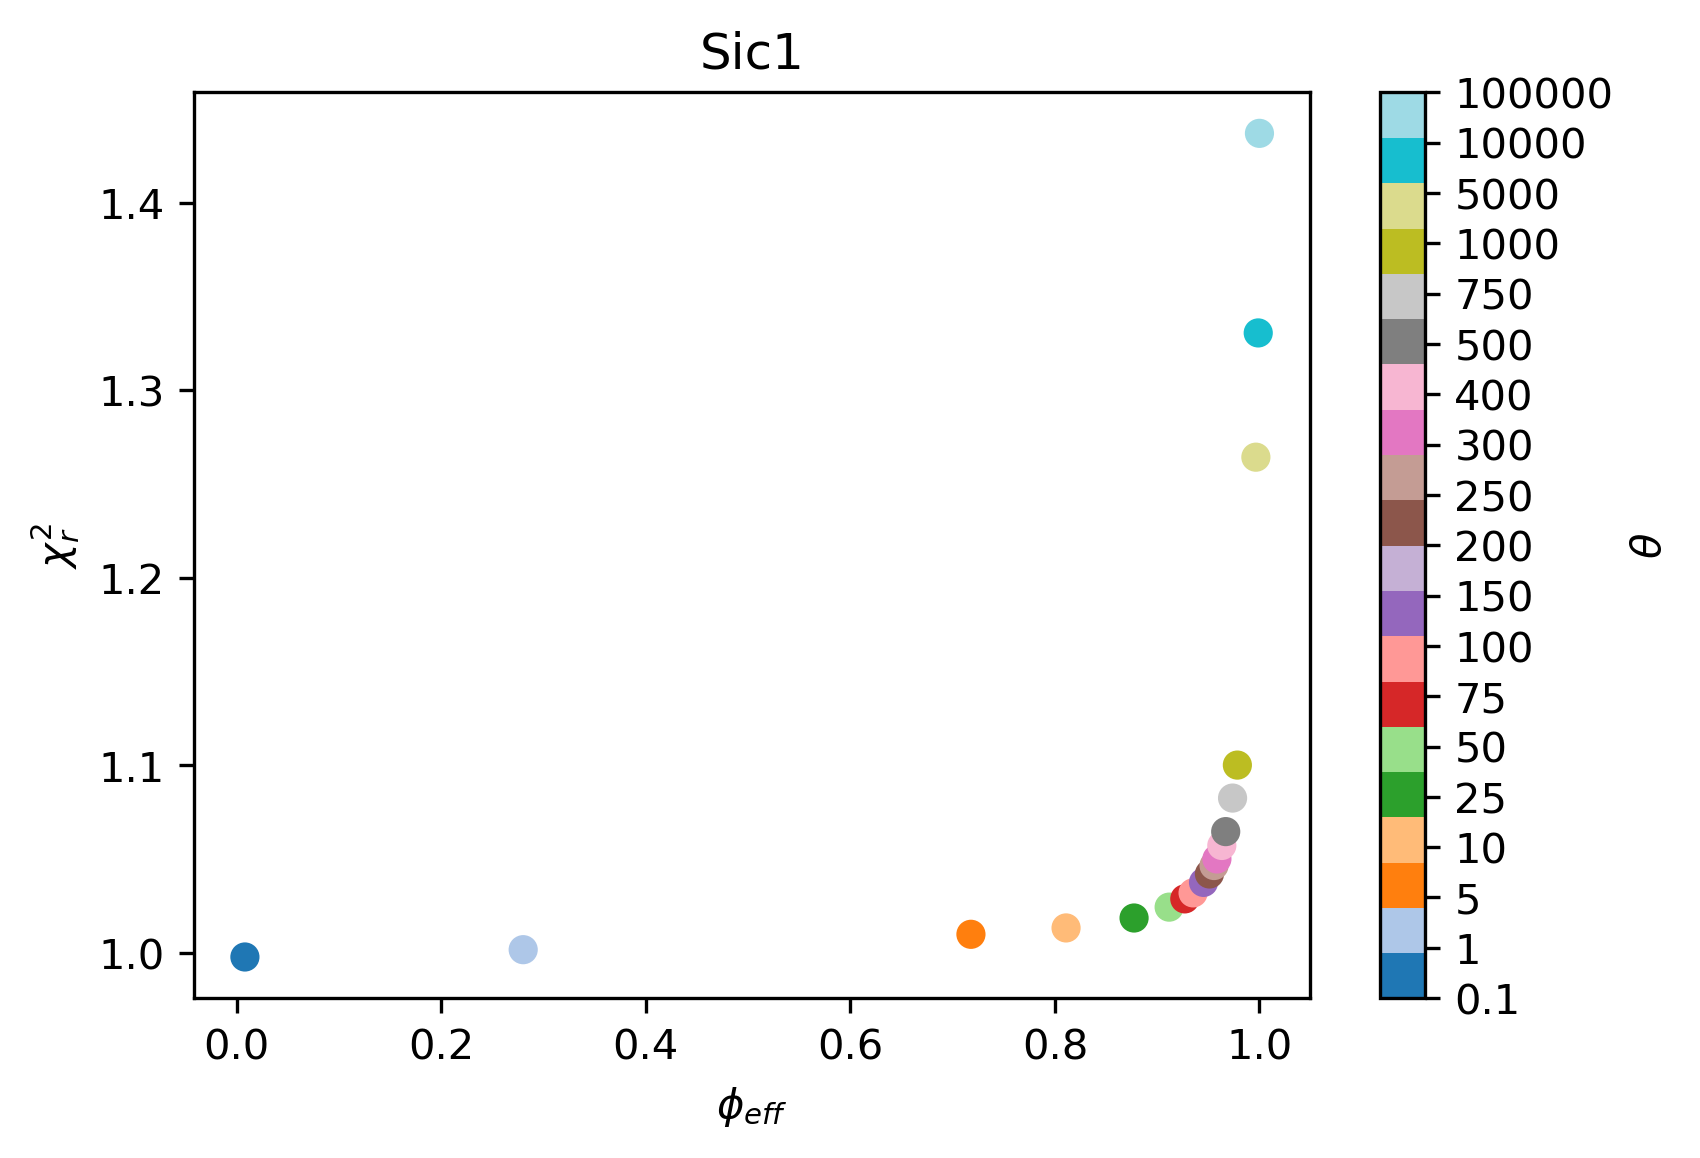

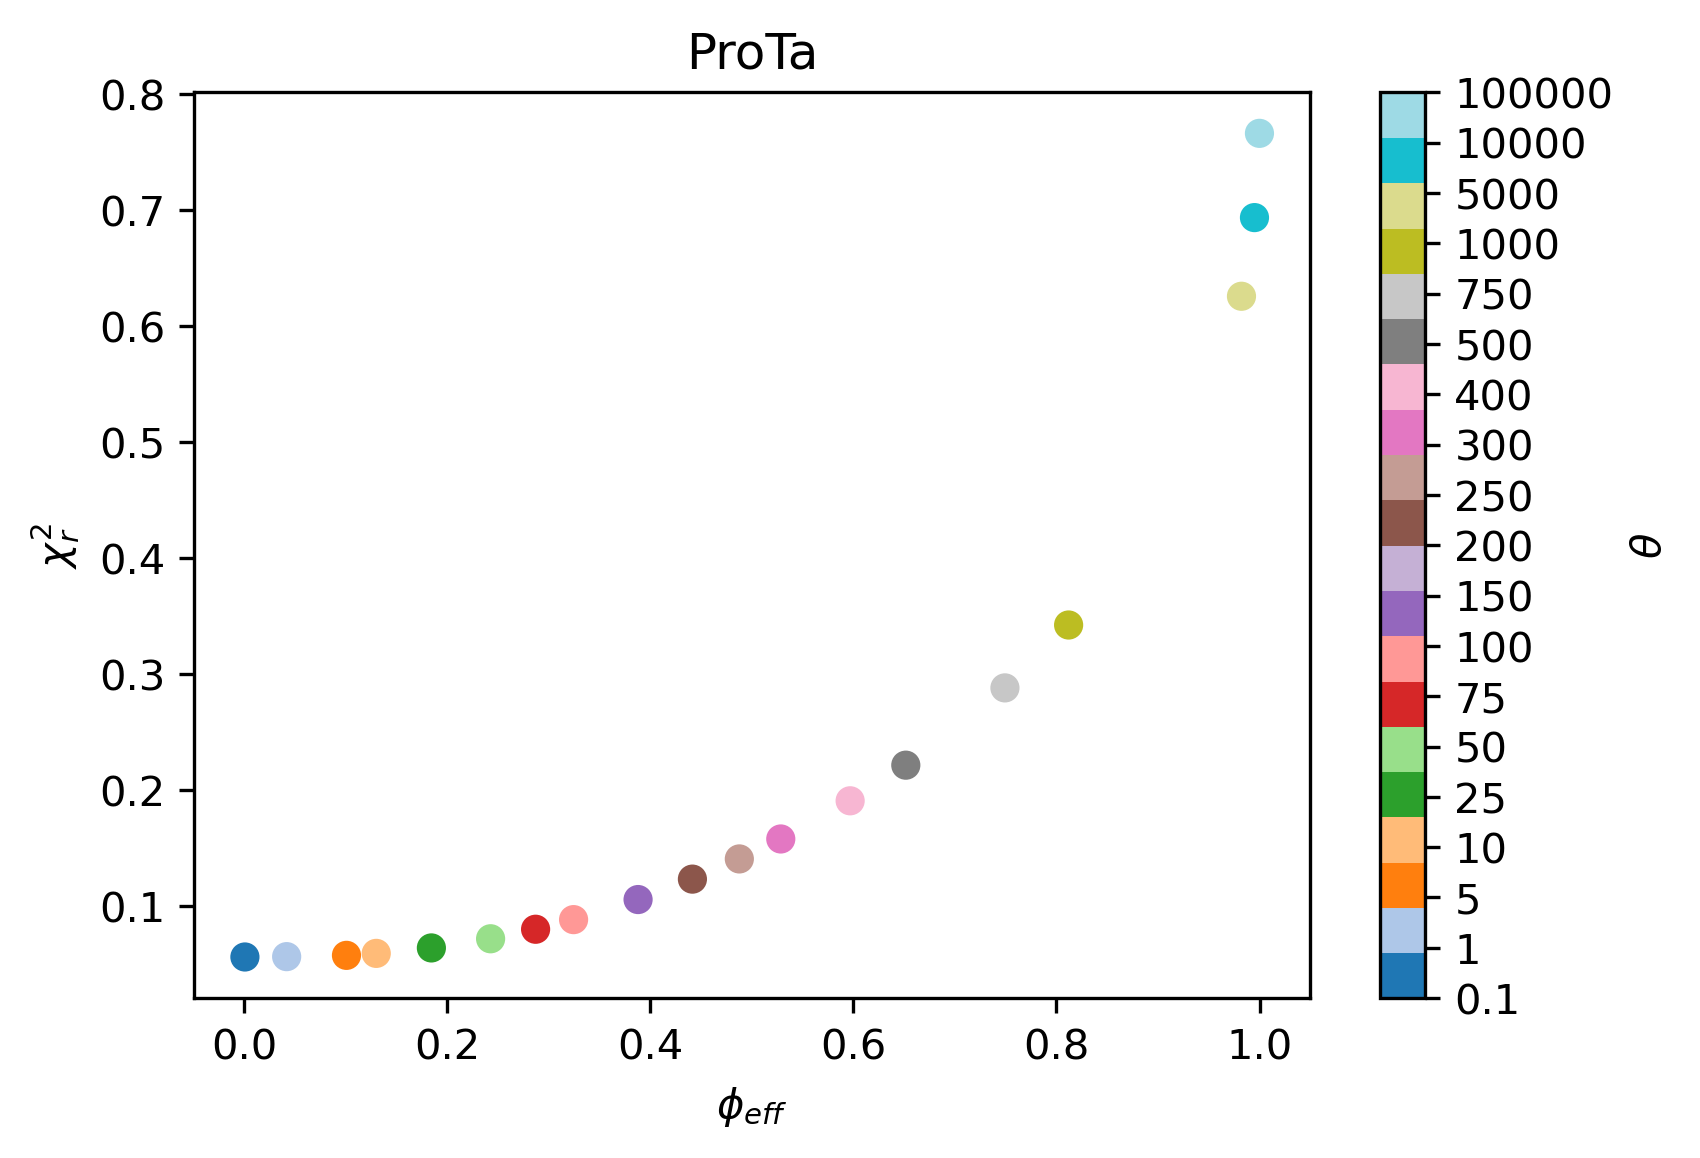

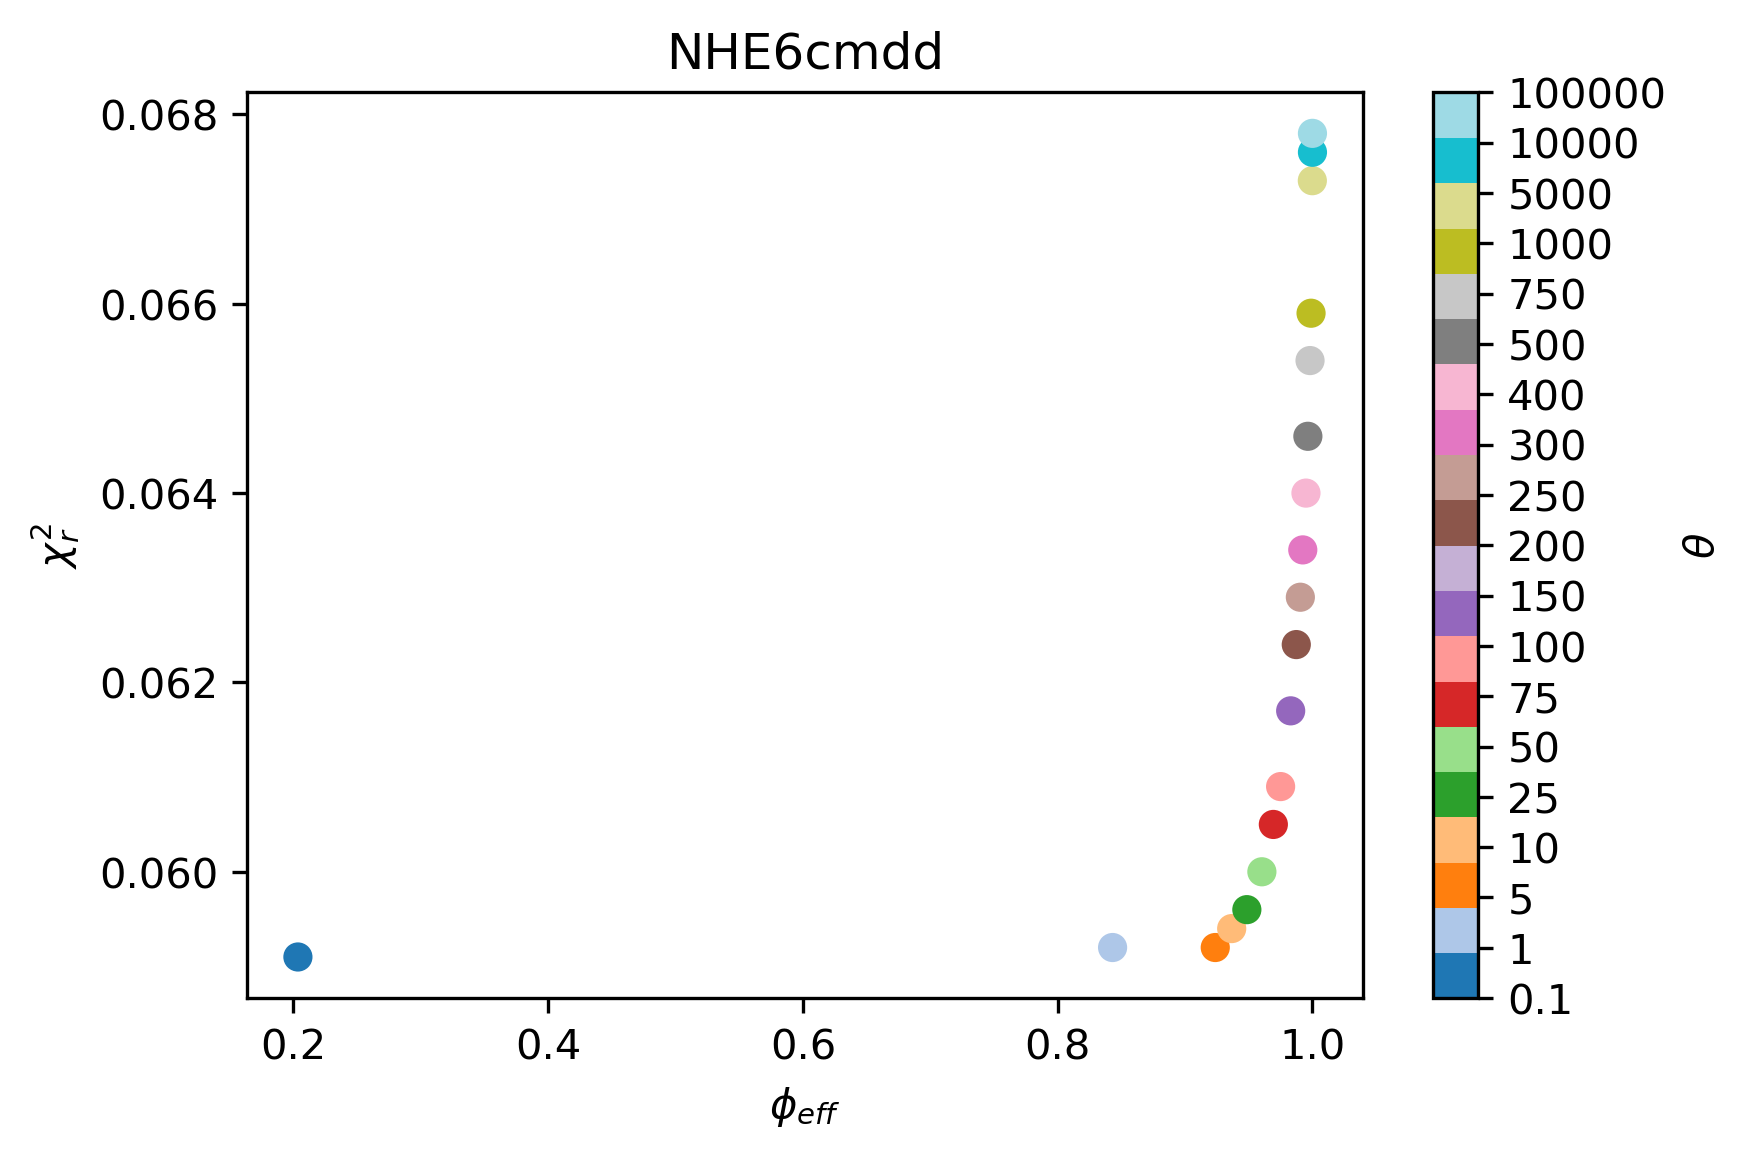

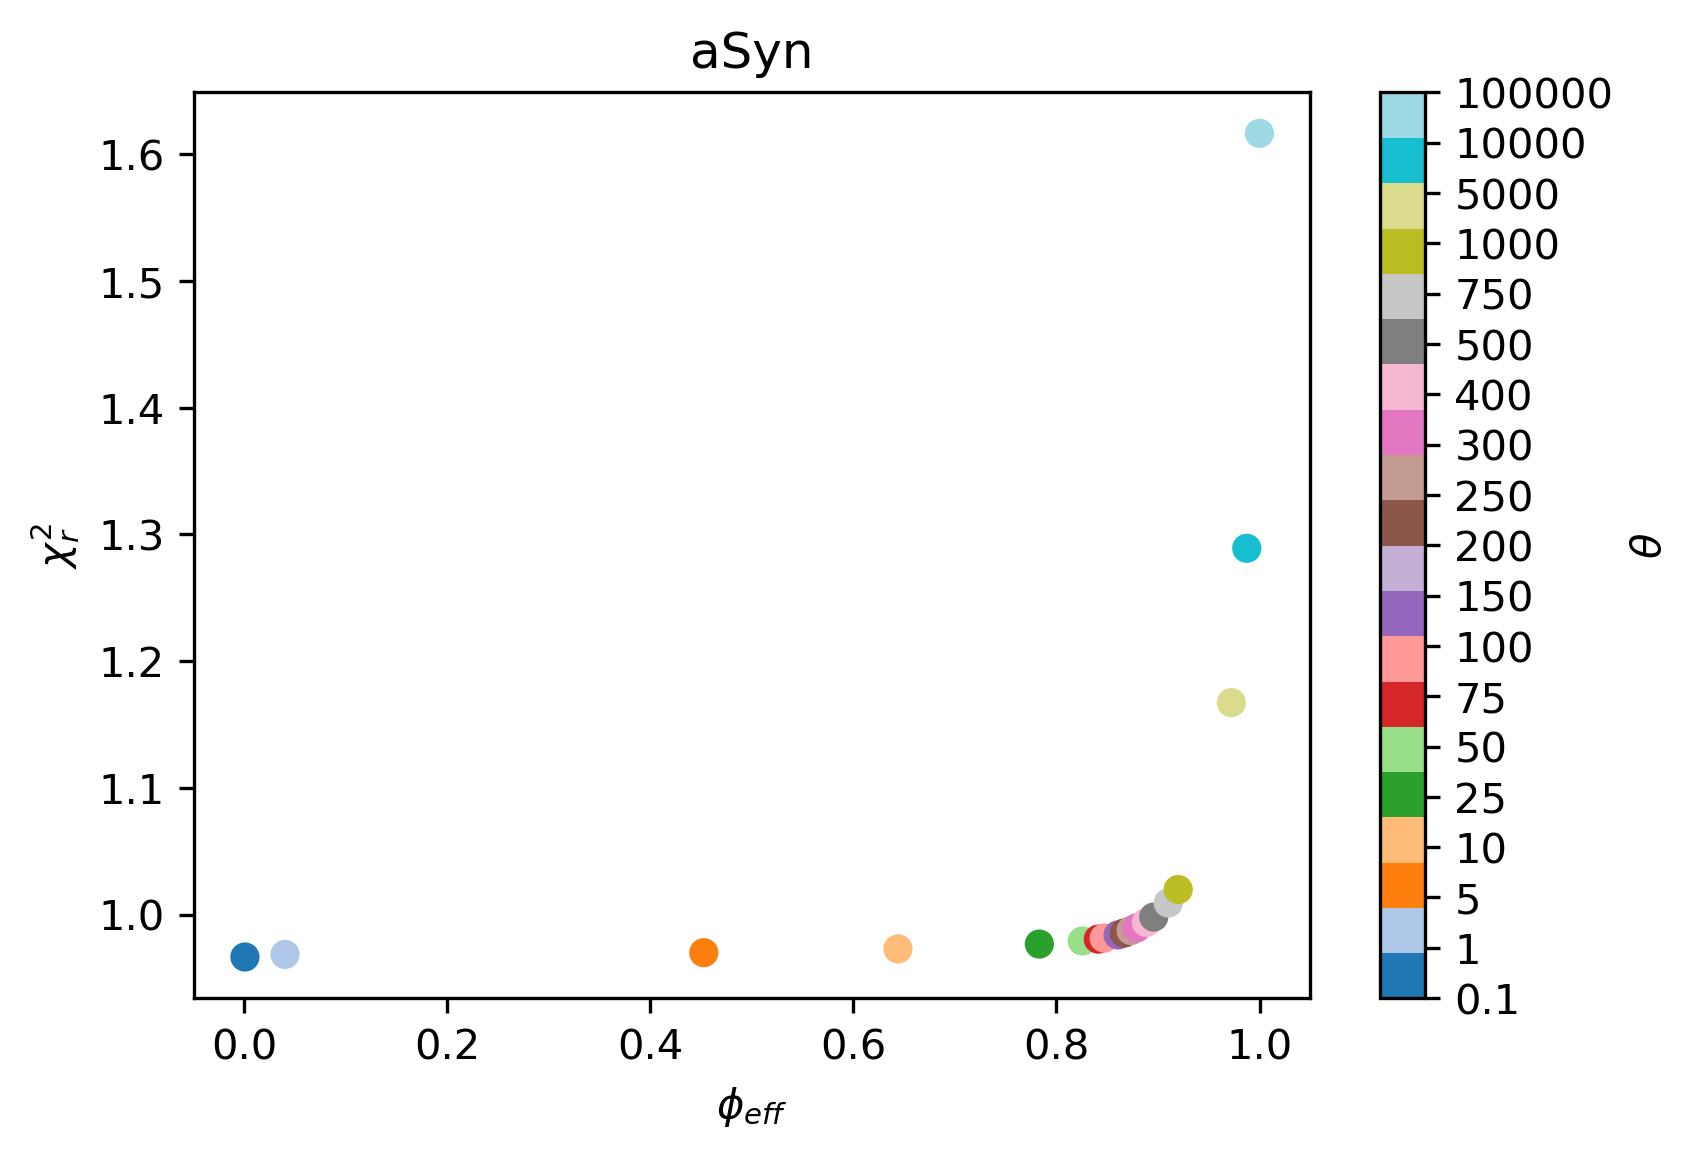

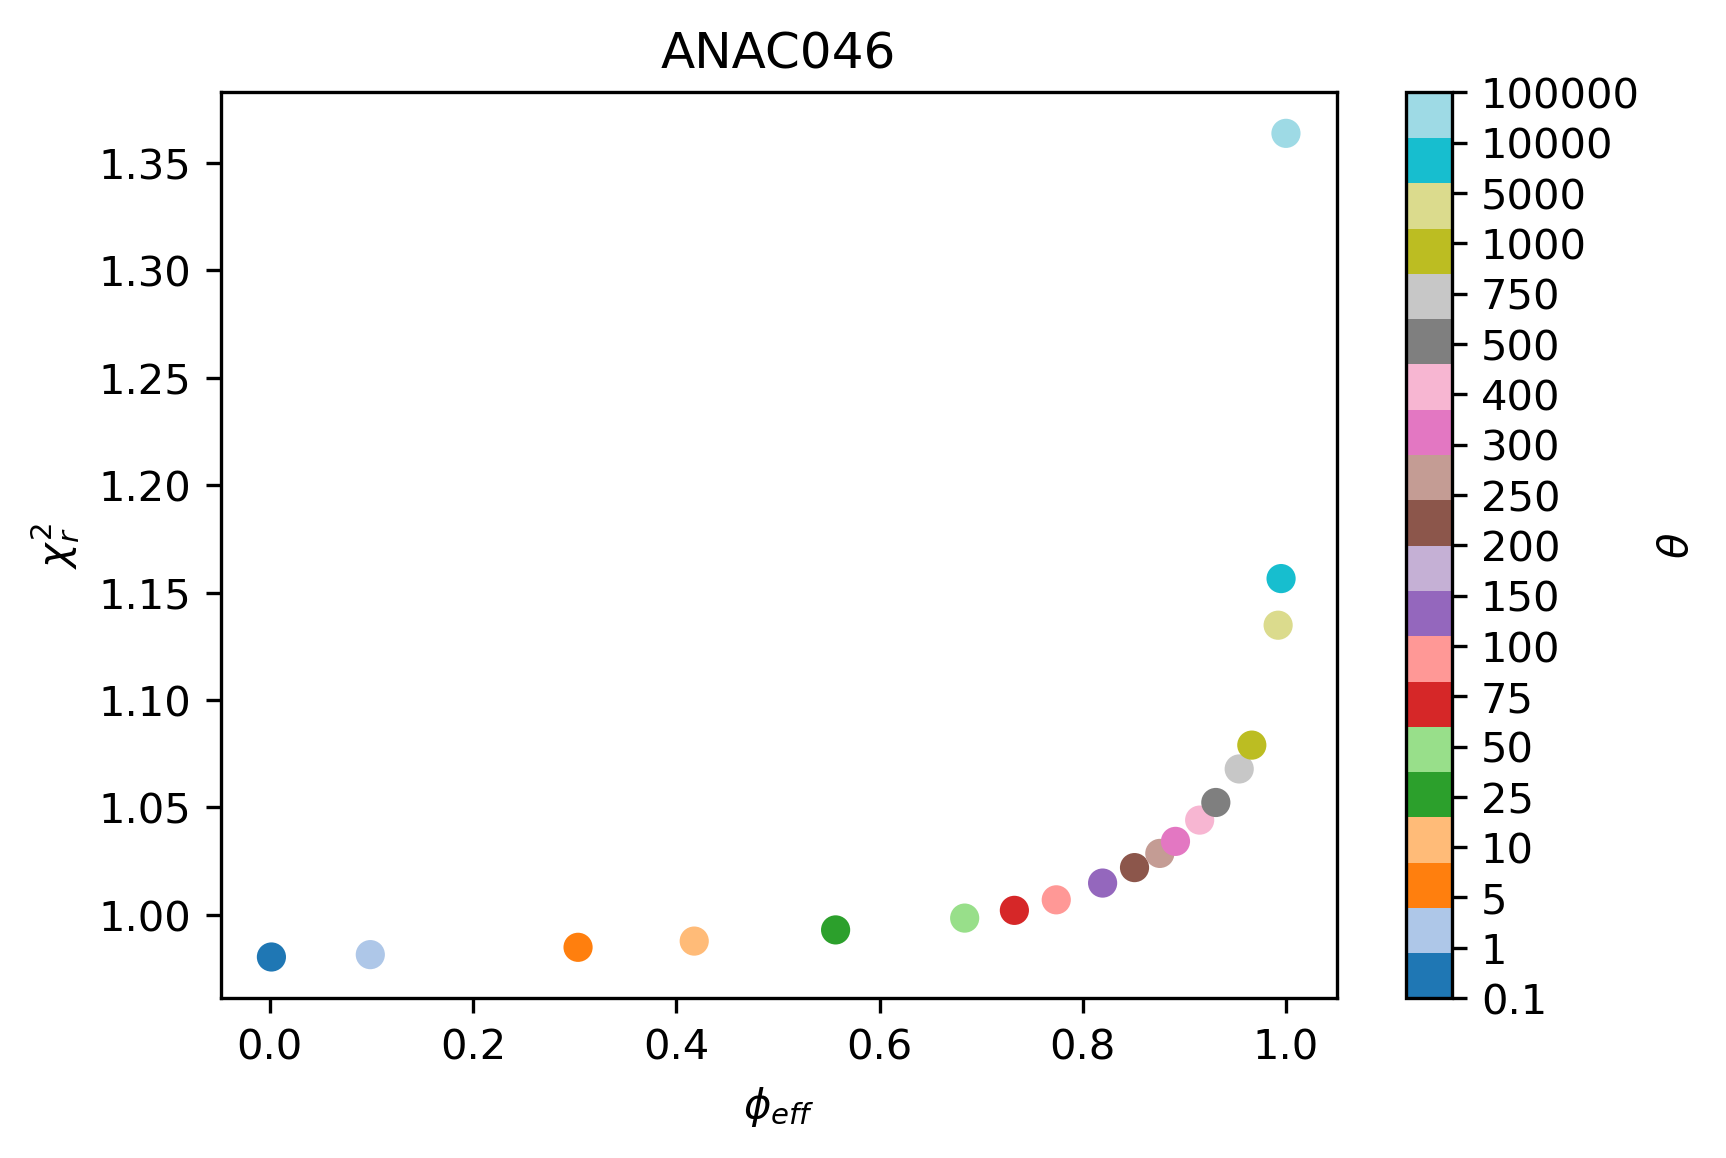

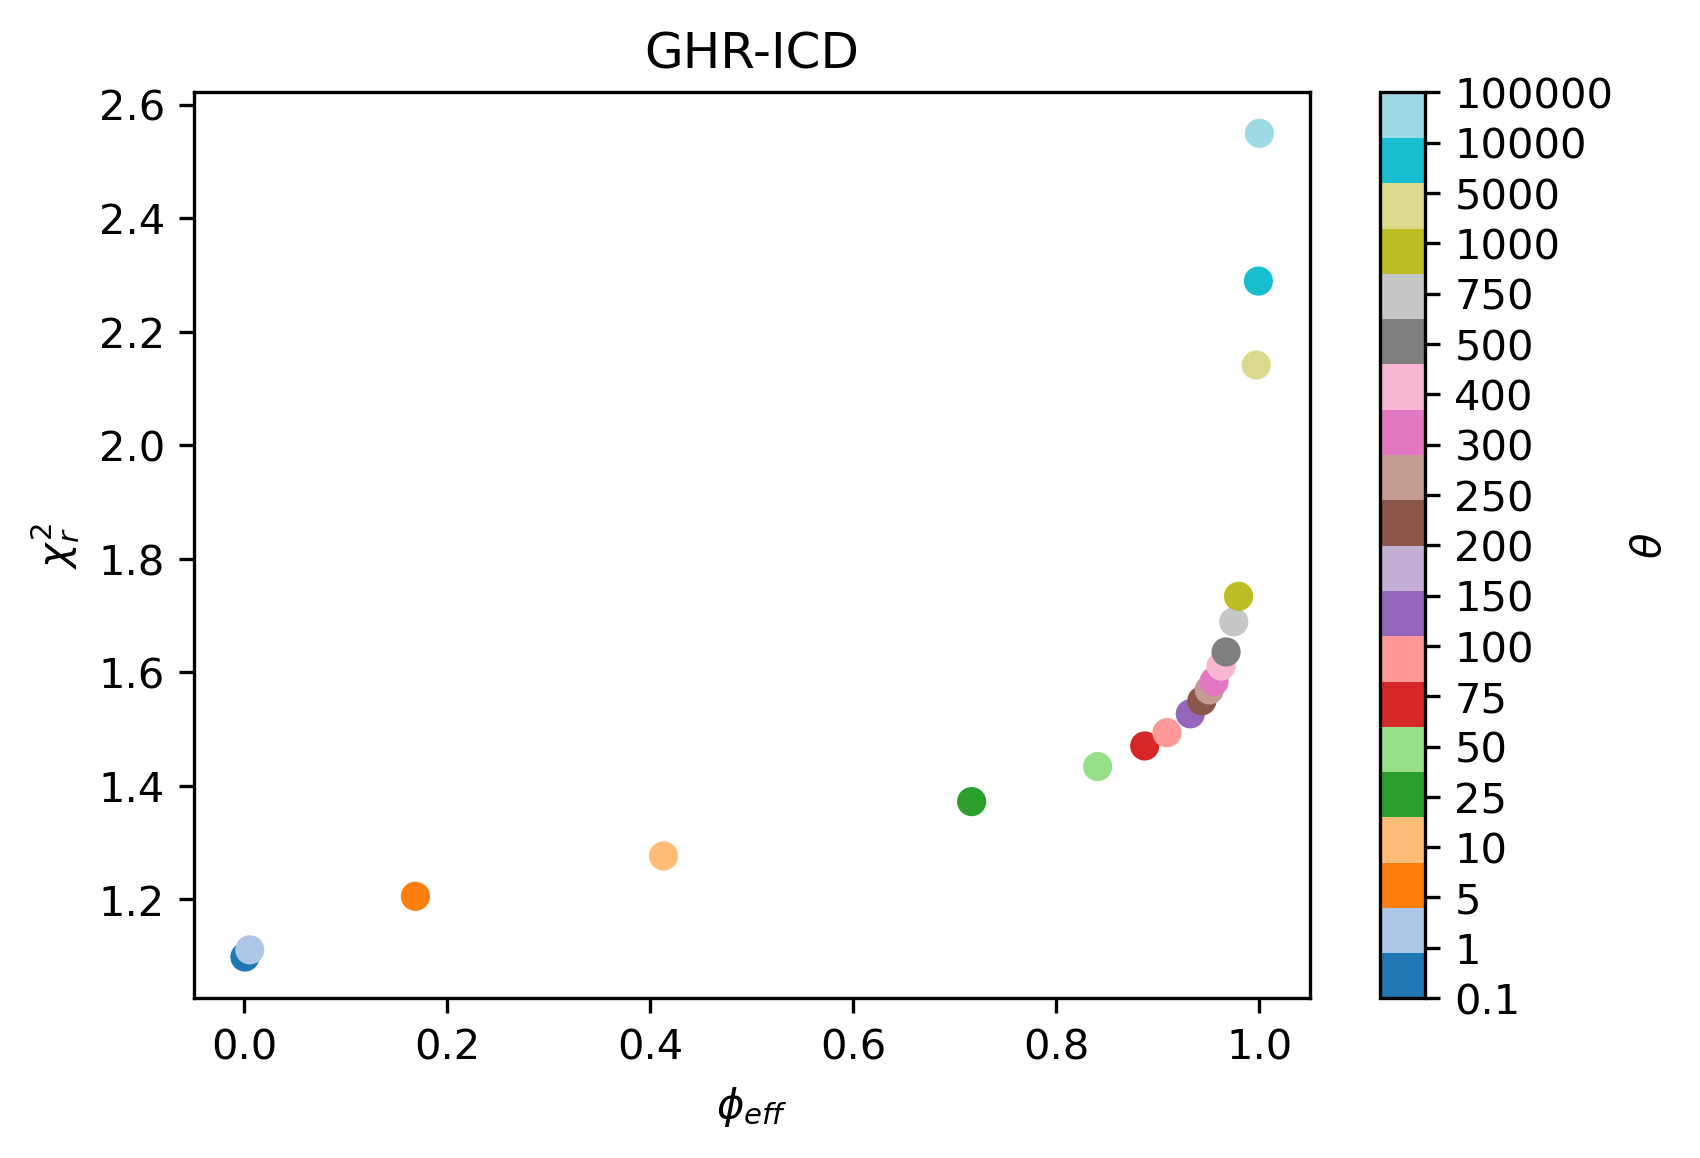

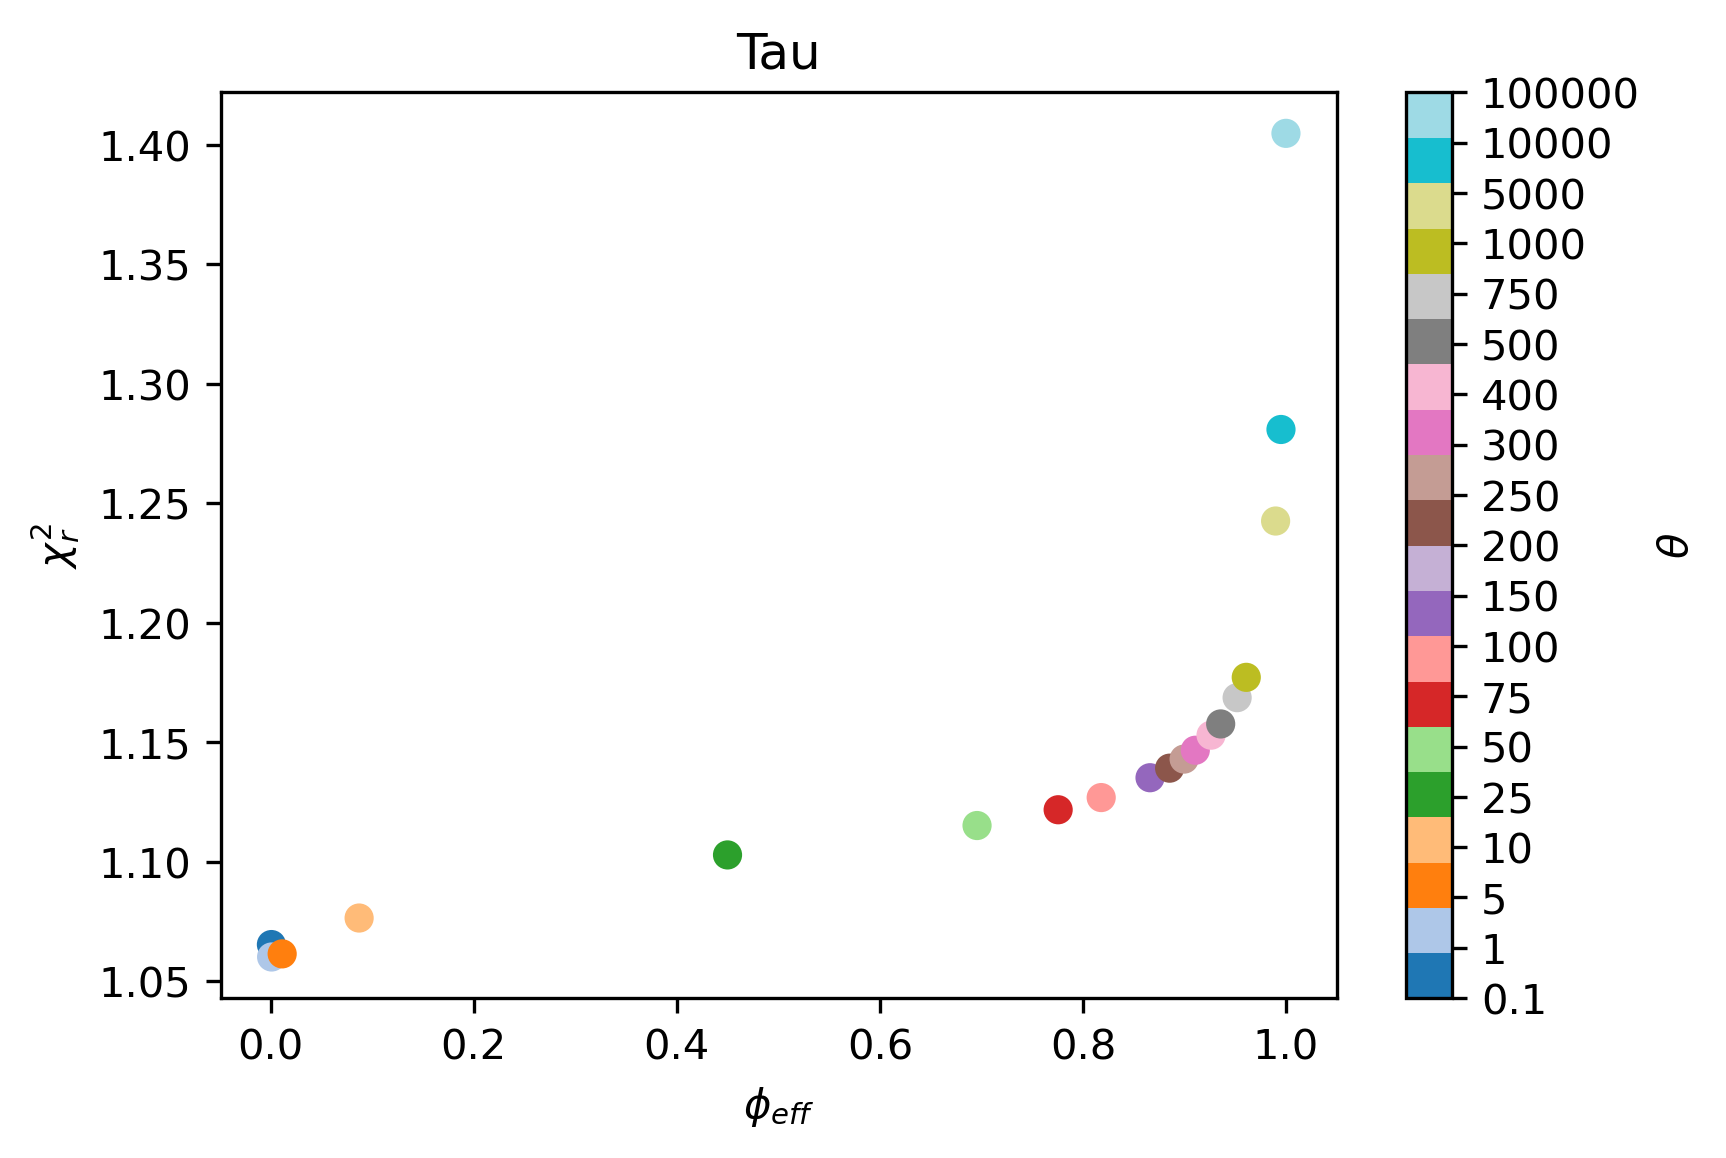

In [85]:
thetas = [ 0.1, 1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 5000, 10000, 100000  ]
BME_tscan = {}
for idp in dataset.index:
    BME_tscan[idp] = []
    for t in thetas:
        f_ = list(filter(lambda x: x.startswith('t'+str(t)+'_ibme_'), os.listdir(idp+'/BME')))
        f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
        for l in open(idp+'/BME/'+f_[-1], 'r').readlines():
            if l.startswith('CHI2 after optimization:'):
                chi2 = float(l.split()[-1])
            elif l.startswith('Fraction of effective frames:'):
                phi = float(l.split()[-1])
        BME_tscan[idp].append([t,chi2,phi])
    
    tscan = np.array(BME_tscan[idp])
    plt.fig = plt.figure(dpi=300)
    plt.scatter(tscan[...,2], tscan[...,1], c=range(len(tscan)), cmap=plt.cm.get_cmap('tab20'))
    cbar = plt.colorbar(ticks=range(len(tscan)), label=r'$\theta$')
    cbar.ax.set_yticklabels(thetas)
    plt.title(idp)
    plt.xlabel(r'$\phi_{eff}$')
    plt.ylabel(r'$\chi^2_r$')
    plt.show()

In [89]:
#Choice of thetas
dataset['theta'] = [75, 50, 750, 5, 500, 150, 50, 150]

In [113]:
w = []
calc_saxs = []
for idp in dataset.index:
    f_ = list(filter(lambda x: x.startswith('t'+str(dataset.theta[idp])+'_ibme_'), os.listdir(idp+'/BME')))
    f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
    conv_ndx = f_[-1][:-4].split('_')[2]
    w.append( np.loadtxt(idp+'/BME/t'+str(dataset.theta[idp])+'_'+str(conv_ndx)+'.weights.dat')[...,1] )
    calc_saxs.append( np.loadtxt(idp+'/BME/t'+str(dataset.theta[idp])+'_'+str(conv_ndx)+'.calc.dat')[...,1:] )
dataset['weights'] = w
dataset['calc_saxs'] = calc_saxs

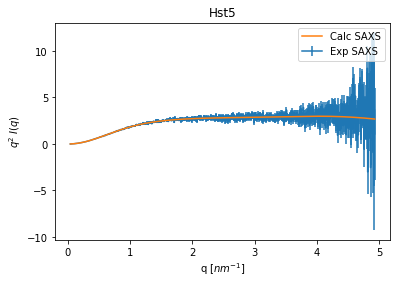

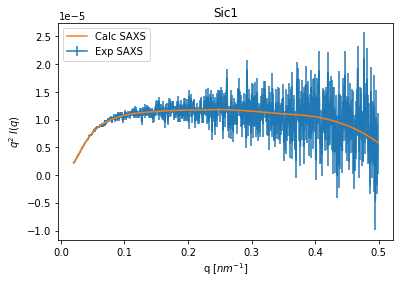

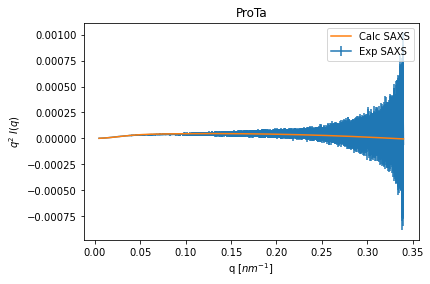

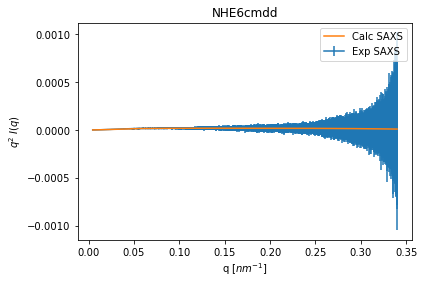

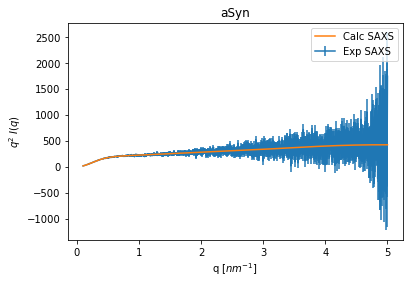

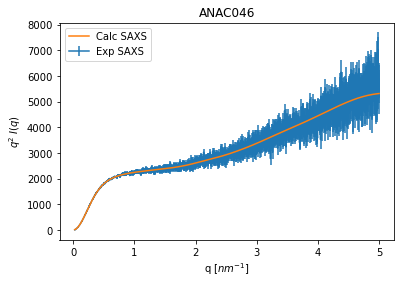

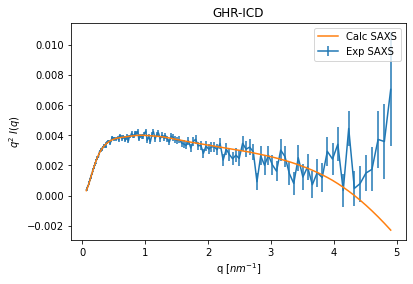

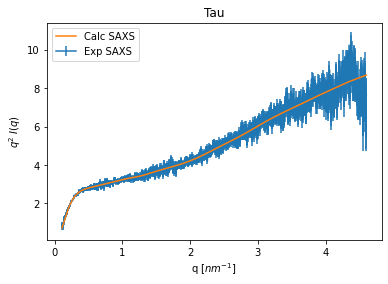

In [118]:
for p in dataset.index:
    q = dataset.exp_saxs[p][...,0]
    kratky_exp = (q**2)*dataset.exp_saxs[p][...,1]
    kratky_err = (q**2)*dataset.exp_saxs[p][...,2]
    calc_i = np.average( dataset.calc_saxs[p], weights=dataset.weights[p], axis=0 )
    kratky_calc = (q**2)*calc_i
    plt.errorbar(q,kratky_exp,kratky_err, label='Exp SAXS')
    plt.plot(q,kratky_calc,zorder=100, label='Calc SAXS')
    plt.legend()
    plt.xlabel(r'q [$nm^{-1}$]')
    plt.ylabel(r'$q^2$ $I(q)$')
    plt.title(p)
    #plt.savefig(p+'_saxs.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
    plt.show()

### Rh forward models comparison

In [127]:
Rh_Nyg = {}
Rh_Kirk = {}
Rh_HR = {}
for p in dataset.index:
    Rh_Nyg[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10, dataset.weights[p] )
    Rh_Kirk[p] = kde( np.loadtxt(p+'/Rh_Kirk.dat'), dataset.weights[p] )
    Rh_HR[p] = kde( np.loadtxt(p+'/Rh_HR.dat'), dataset.weights[p])

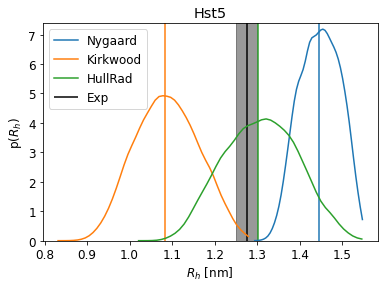

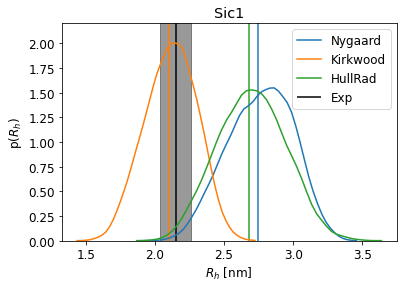

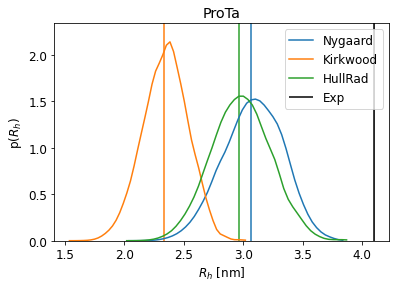

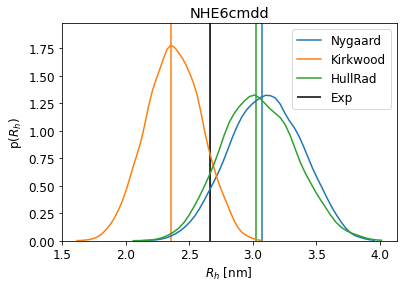

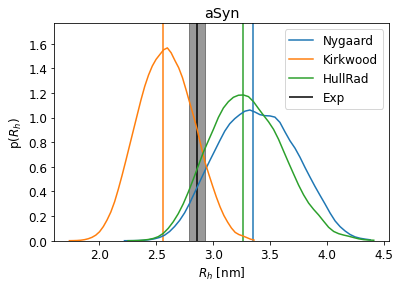

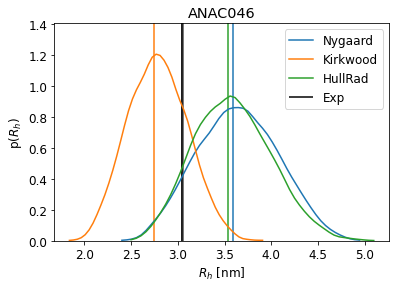

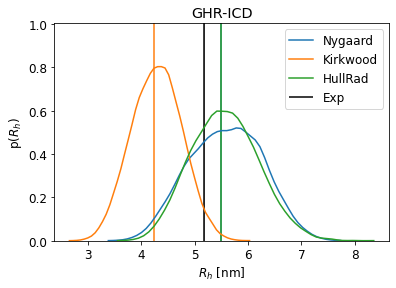

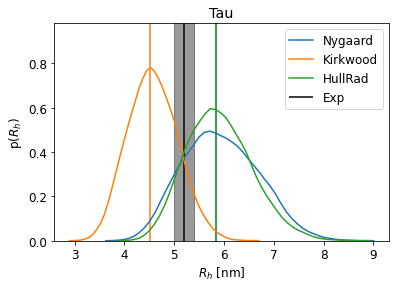

In [133]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['font.size'] = 12
for p in dataset.index:
    plt.plot(Rh_Nyg[p][0], Rh_Nyg[p][1], label='Nygaard',color=c[0])
    plt.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0])
    plt.plot(Rh_Kirk[p][0], Rh_Kirk[p][1], label='Kirkwood',color=c[1])
    plt.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1])
    plt.plot(Rh_HR[p][0], Rh_HR[p][1], label='HullRad',color=c[2])
    plt.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2])
    plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    plt.title(p)
    plt.ylabel(r'p($R_h$)')
    plt.xlabel(r'$R_h$ [nm]')
    plt.legend()
    #plt.savefig(p+'.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
    plt.show()